# Deep learning

In [1]:
%load_ext autoreload
%autoreload 2

import tasks.data
import tasks.torch_train_eval
import tasks.adaptive_train_eval
import tasks.calibration

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

import random
import os


DATA_DIR = "data/office"
OUTPUT_DIR = "output"

SOURCE_DATASET = "amazon"
SOURCE_VAL_SPLIT = .15
SOURCE_TEST_SPLIT = .1

TARGET_VAL_SPLIT = .15
TARGET_TEST_SPLIT = .15
TARGET_DATASET = "webcam"

FINETUNED_MODEL_DIR = os.path.join(OUTPUT_DIR, "classifier")
ADAPTIVE_MODEL_DIR = os.path.join(OUTPUT_DIR, "adaptive")

FINETUNE_MODEL = False
ADAPT_MODEL = True

RANDOM_SEED = 42
BATCH_SIZE = 3

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import imageio.v2 as imageio
from torchvision.transforms import v2


def resnet_preprocessor(image: np.ndarray) -> np.ndarray:
    """
    Preprocesses an image for ResNet model.

    :param numpy.ndarray image: The input image.
    :return: Preprocessed image.
    :rtype: numpy.ndarray
    """
    preprocess = torchvision.transforms.Compose(
        [    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
            v2.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )

    image = preprocess(image)
    return image


def image_read_func(image_path):
    return imageio.imread(image_path, pilmode='RGB')


In [3]:
import random



def train_val_test_split(
    dataset: tasks.data.ImageDataset, val_ratio: float, test_ratio: float
):
    """
    Splits into pure ImageDataset objects, not Subsets, to allow for dynamic changes in the
    underlying data using the custom class API.
    """
    train_ratio = 1 - val_ratio - test_ratio

    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)

    # Split the dataset into train, validation, and test sets
    train_dataset = tasks.data.ImageDataset(
        parser_func=dataset.parser_func,
        preprocessing_func=dataset.preprocessing_func,
        label_encoder=dataset.label_encoder,
    )
    val_dataset = tasks.data.ImageDataset(
        parser_func=dataset.parser_func,
        preprocessing_func=dataset.preprocessing_func,
        label_encoder=dataset.label_encoder,
    )
    test_dataset = tasks.data.ImageDataset(
        parser_func=dataset.parser_func,
        preprocessing_func=dataset.preprocessing_func,
        label_encoder=dataset.label_encoder,
    )

    random.shuffle(dataset.samples)
    for idx, sample in enumerate(dataset.samples):
        if idx < train_size:
            train_dataset.add(sample[0], sample[1])
        elif idx < train_size + val_size:
            val_dataset.add(sample[0], sample[1])
        else:
            test_dataset.add(sample[0], sample[1])

    return train_dataset, val_dataset, test_dataset


source_dataset = tasks.data.ImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
)
source_dataset.load_from_directory(os.path.join(DATA_DIR, SOURCE_DATASET))

source_train_dataset, source_val_dataset, source_test_dataset = train_val_test_split(
    source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
)

  0%|          | 0/31 [00:00<?, ?it/s]

In [4]:
def create_padded_dataloader(
    dataset: tasks.data.ImageDataset,
    shuffle: bool = True,
):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        collate_fn=tasks.data.collate_pad,
    )


source_train_loader = create_padded_dataloader(source_train_dataset, shuffle=True)
source_val_loader = create_padded_dataloader(source_val_dataset, shuffle=False)
source_test_loader = create_padded_dataloader(source_test_dataset, shuffle=False)

In [5]:
import pickle


def try_load_weights(model, weights_path: str):
    try:
        model.load_state_dict(torch.load(weights_path))
    except Exception as e:
        print("Cannot load proper weights: ", e)
    return model


def try_load_history(history_path):
    try:
        with open(history_path, 'rb') as handle:
            history = pickle.load(handle)
    except:
        print("No history found in path ", history_path)
        history = None

    return history

In [6]:
import torchinfo


model = torch.hub.load(
    "pytorch/vision:v0.10.0", "resnet18", weights="DEFAULT"
).to(device)
model = try_load_weights(model, os.path.join(FINETUNED_MODEL_DIR, "model.pt"))

torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 300, 300))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [3, 1000]                 --
├─Conv2d: 1-1                            [3, 64, 150, 150]         9,408
├─BatchNorm2d: 1-2                       [3, 64, 150, 150]         128
├─ReLU: 1-3                              [3, 64, 150, 150]         --
├─MaxPool2d: 1-4                         [3, 64, 75, 75]           --
├─Sequential: 1-5                        [3, 64, 75, 75]           --
│    └─BasicBlock: 2-1                   [3, 64, 75, 75]           --
│    │    └─Conv2d: 3-1                  [3, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-2             [3, 64, 75, 75]           128
│    │    └─ReLU: 3-3                    [3, 64, 75, 75]           --
│    │    └─Conv2d: 3-4                  [3, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-5             [3, 64, 75, 75]           128
│    │    └─ReLU: 3-6                    [3, 64, 75, 75]           --
│

In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0005)
# disable lr for adam
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.05)
previous_history = try_load_history(os.path.join(FINETUNED_MODEL_DIR, "history.pickle"))


if FINETUNE_MODEL:
    model, history = tasks.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_loader,
        source_val_loader,
        output_dir=output_path,
        num_epochs=200,
        patience=10,
        warmup_period=25,
        previous_history=previous_history
    )
else:
    history = previous_history

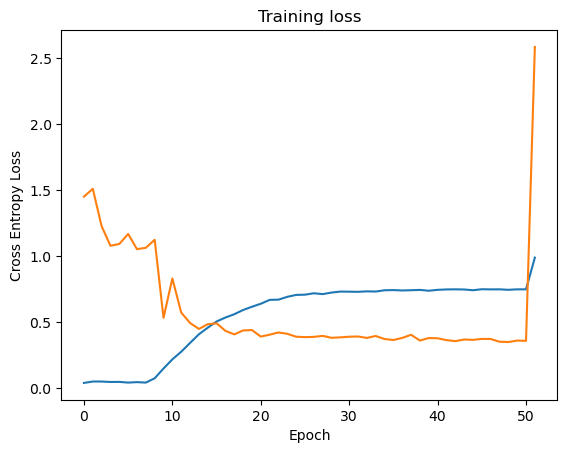

In [8]:
plt.plot(np.array(range(len(history["train_loss"]))), history["train_loss"])
plt.plot(np.array(range(len(history["val_loss"]))), history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training loss")
plt.show()

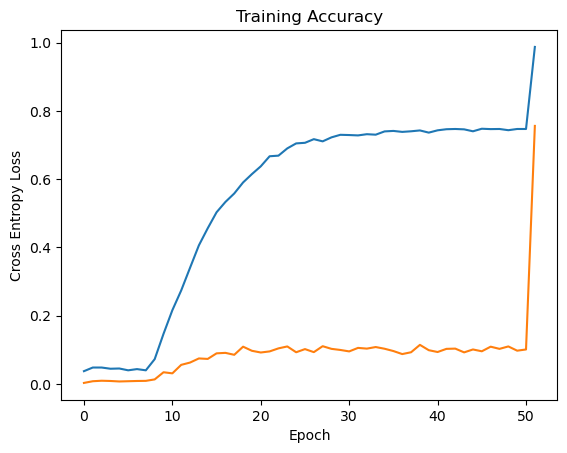

In [9]:
# validation accuracy has been calculated wrong here, ignore it for now
plt.plot(np.array(range(len(history["train_acc"]))), history["train_acc"])
plt.plot(np.array(range(len(history["val_acc"]))), history["val_acc"])

plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Accuracy")
plt.show()

In [11]:
# save logits for later calibration
source_actual, source_predicted = tasks.torch_train_eval.test(
    model, source_test_loader, device
)
class_names = source_dataset.label_encoder.classes_

print(
    sklearn.metrics.classification_report(
        source_actual,
        source_predicted,
        zero_division=0,
        target_names=class_names,
        labels=np.arange(0, len(class_names), 1),
    )
)

  0%|          | 0/95 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       1.00      1.00      1.00         7
            bike       1.00      1.00      1.00         5
     bike_helmet       1.00      1.00      1.00         7
        bookcase       0.88      1.00      0.93         7
          bottle       0.75      0.75      0.75         4
      calculator       1.00      1.00      1.00         8
      desk_chair       1.00      1.00      1.00        10
       desk_lamp       1.00      1.00      1.00         8
desktop_computer       0.79      0.85      0.81        13
    file_cabinet       1.00      0.90      0.95        10
      headphones       1.00      1.00      1.00         5
        keyboard       1.00      0.82      0.90        17
 laptop_computer       1.00      1.00      1.00        13
     letter_tray       0.83      0.83      0.83         6
    mobile_phone       1.00      0.89      0.94         9
         monitor       1.00      1.00      1.00         9
           mo

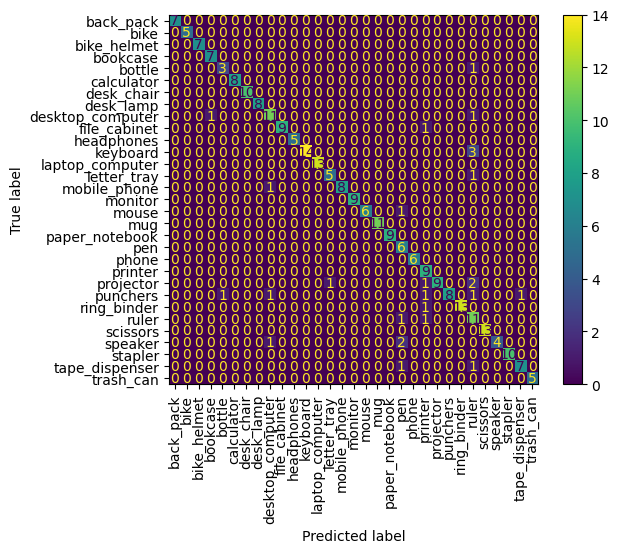

In [12]:
source_cf_matrix = sklearn.metrics.confusion_matrix(source_actual, source_predicted)
display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=source_cf_matrix, display_labels=class_names
)
display.plot()
plt.xticks(rotation=90)
plt.show()

In [13]:
target_dataset = tasks.data.ImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
    label_encoder=source_dataset.label_encoder # use same classes
)
target_dataset.load_from_directory(os.path.join(DATA_DIR, TARGET_DATASET))

target_train_dataset, target_val_dataset, target_test_dataset = train_val_test_split(
    target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
)

target_train_loader = create_padded_dataloader(target_train_dataset, shuffle=True)
target_test_loader = create_padded_dataloader(target_test_dataset, shuffle=False)

  0%|          | 0/31 [00:00<?, ?it/s]

In [14]:
target_actual, target_predicted = tasks.torch_train_eval.test(model, target_test_loader, device)
class_names = target_dataset.label_encoder.classes_

print(
    sklearn.metrics.classification_report(
        target_actual,
        target_predicted,
        zero_division=0,
        target_names=class_names,
        labels=np.arange(0, len(class_names), 1),
    )
)

  0%|          | 0/40 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.80      0.80      0.80         5
            bike       0.00      0.00      0.00         2
     bike_helmet       0.25      0.25      0.25         4
        bookcase       0.00      0.00      0.00         1
          bottle       0.00      0.00      0.00         2
      calculator       0.33      0.25      0.29         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.12      0.50      0.20         2
    file_cabinet       0.00      0.00      0.00         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.00      0.00      0.00         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.00      0.00      0.00         5
         monitor       0.00      0.00      0.00         6
           mo

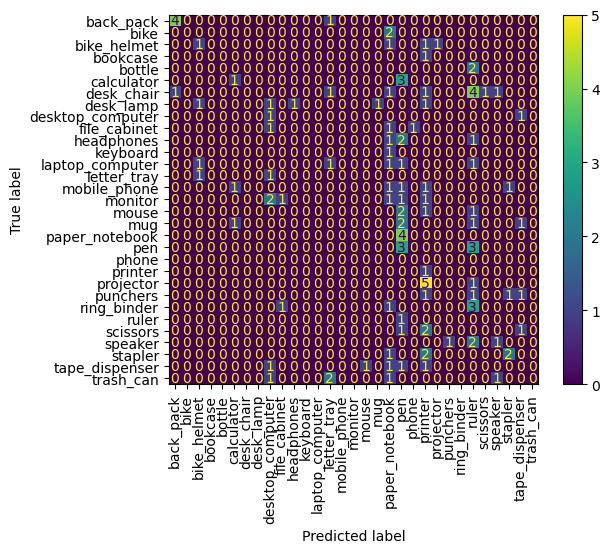

In [15]:
target_cf_matrix = sklearn.metrics.confusion_matrix(target_actual, target_predicted)
display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=target_cf_matrix, display_labels=class_names
)
display.plot()
plt.xticks(rotation=90)
plt.show()

## Domain Adaptation

In [16]:
unlabeled_dataset = tasks.data.UnlabeledImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
)
unlabeled_dataset.load_from_image_dataset(target_train_dataset)

source_history = try_load_history(os.path.join(ADAPTIVE_MODEL_DIR, "source_history.pickle"))
target_history = try_load_history(os.path.join(ADAPTIVE_MODEL_DIR, "target_history.pickle"))

No history found in path  output/adaptive/source_history.pickle
No history found in path  output/adaptive/target_history.pickle


In [17]:
if ADAPT_MODEL:
    tasks.adaptive_train_eval.train_adaptive_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        source_train_dataset=source_train_dataset,
        source_val_dataset=source_val_dataset,
        source_dataloader_initializer=lambda dataset: torch.utils.data.Dataloader(
            dataset, batch_size=BATCH_SIZE, shuffle=True
        ),
        target_train_dataset=unlabeled_dataset,
        target_val_dataset=target_val_dataset,
        output_dir=ADAPTIVE_MODEL_DIR,
        num_epochs=20,
        previous_source_history=source_history,
        previous_target_history=target_history,
    )

## Dustbin